In [1]:
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC


In [2]:
## Importando os Dados

In [3]:
raw_dir = os.path.join("..", "data", "raw")
files = os.listdir(raw_dir)
print("Arquivos em data/raw:", files)

Arquivos em data/raw: ['bossa_nova.csv', 'funk.csv', 'gospel.csv', 'lyrics.zip', 'sertanejo.csv']


In [4]:
raw_dir = os.path.join("..", "data", "raw")
dfs = []
for fname in os.listdir(raw_dir):
    if fname.lower().endswith(".csv"):
        genre = os.path.splitext(fname)[0]
        temp = pd.read_csv(os.path.join(raw_dir, fname))
        temp['genre'] = genre
        dfs.append(temp)

df = pd.concat(dfs, ignore_index=True)
print(df.shape)
print(df['genre'].value_counts())

(3200, 2)
genre
bossa_nova    800
funk          800
gospel        800
sertanejo     800
Name: count, dtype: int64


In [5]:
df.head()

,lyric,genre
0,\nEu sei que vou te amar\nPor toda a minha vi...,bossa_nova
1,\nOlha que coisa mais linda\nMais cheia de gr...,bossa_nova
2,\nEra uma casa\nMuito engraçada\nNão tinha te...,bossa_nova
3,"\nDe tudo, ao meu amor serei atento antes\nE ...",bossa_nova
4,\nQuando a luz dos olhos meus\nE a luz dos ol...,bossa_nova


In [6]:
## Trazendo as Stopwords

nltk.download('stopwords')

stop_pt = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def limpeza_stopwords(text: str) -> str:
    #Quebra de linhas
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    #Converter texto
    text = text.lower().strip()
    #Tirar Acentuação
    text = unidecode(text)
    #Tokenizar
    text = re.sub(r'[^a-z\s]', '', text)
    #remoção stopwords
    tokens = text.split()
    #Reconstrução de base
    tokens = [tok for tok in tokens if tok not in stop_pt]
    return ' '.join(tokens)

In [8]:
df['cleaned'] = df['lyric'].astype(str).apply(limpeza_stopwords)

In [9]:
df[['lyric', 'cleaned']].head()

,lyric,cleaned
0,\nEu sei que vou te amar\nPor toda a minha vi...,sei vou amar toda vida vou amar cada despedida...
1,\nOlha que coisa mais linda\nMais cheia de gr...,olha coisa linda cheia graca menina vem passa ...
2,\nEra uma casa\nMuito engraçada\nNão tinha te...,casa engracada nao teto nao nada ninguem podia...
3,"\nDe tudo, ao meu amor serei atento antes\nE ...",tudo amor atento antes tal zelo sempre tanto f...
4,\nQuando a luz dos olhos meus\nE a luz dos ol...,luz olhos luz olhos resolvem encontrar ai bom ...


In [10]:
##Bases estatisticas

df['n_words'] = df['cleaned'].str.split().apply(len)
df['n_chars'] = df['cleaned'].str.len()

print(df[['n_words','n_chars']].describe())

           n_words      n_chars
count  3200.000000  3200.000000
mean    109.699687   667.995312
std      70.894879   443.202162
min       1.000000     3.000000
25%      62.000000   375.000000
50%      91.000000   551.500000
75%     142.000000   854.000000
max     919.000000  6571.000000


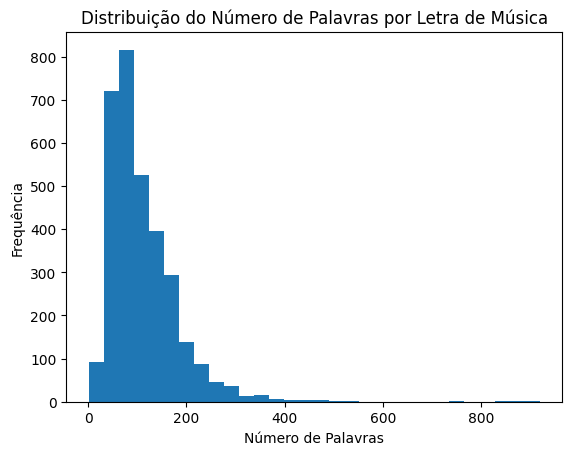

In [11]:
# Histograma de número de palavras
plt.figure()
plt.hist(df['n_words'], bins=30)
plt.title("Distribuição do Número de Palavras por Letra de Música")
plt.xlabel("Número de Palavras")
plt.ylabel("Frequência")
plt.show()

In [12]:
df[['n_words','n_chars']].describe().T

,count,mean,std,min,25%,50%,75%,max
n_words,3200.0,109.699687,70.894879,1.0,62.0,91.0,142.0,919.0
n_chars,3200.0,667.995312,443.202162,3.0,375.0,551.5,854.0,6571.0


In [13]:
## Tabela de top-Palavras Frequentes

from collections import Counter

all_tokens = [tok for lyric in df['cleaned'] for tok in lyric.split()]
freq = Counter(all_tokens)
top20 = freq.most_common(20)

pd.DataFrame(top20, columns=['word','count'])

,word,count
0,nao,10694
1,pra,6705
2,voce,6301
3,vai,4527
4,so,3523
5,amor,3368
6,vou,2929
7,deus,2796
8,ta,2495
9,mim,2105


In [14]:
## Refinamento/remoção Stopwords 

custom_sw = {'pra','so','ta','to','ja','ai','hoje','vou','vai','mim'}
stop_pt |= custom_sw

In [15]:
df['cleaned'] = df['lyric'].astype(str).apply(limpeza_stopwords)
df[['lyric','cleaned','genre']].head()

,lyric,cleaned,genre
0,\nEu sei que vou te amar\nPor toda a minha vi...,sei amar toda vida amar cada despedida amar de...,bossa_nova
1,\nOlha que coisa mais linda\nMais cheia de gr...,olha coisa linda cheia graca menina vem passa ...,bossa_nova
2,\nEra uma casa\nMuito engraçada\nNão tinha te...,casa engracada nao teto nao nada ninguem podia...,bossa_nova
3,"\nDe tudo, ao meu amor serei atento antes\nE ...",tudo amor atento antes tal zelo sempre tanto f...,bossa_nova
4,\nQuando a luz dos olhos meus\nE a luz dos ol...,luz olhos luz olhos resolvem encontrar bom deu...,bossa_nova


In [16]:
from collections import Counter

# Junta todos os tokens limpos
all_tokens = [tok for lyric in df['cleaned'] for tok in lyric.split()]

# Conta frequências
freq = Counter(all_tokens)

# Pega as 20 mais comuns
top20 = freq.most_common(20)

# Exibe como DataFrame
top20_df = pd.DataFrame(top20, columns=['word','count'])
display(top20_df)

,word,count
0,nao,10694
1,voce,6301
2,amor,3368
3,deus,2796
4,quero,2089
5,vem,2046
6,tudo,1913
7,vida,1908
8,coracao,1569
9,sei,1522


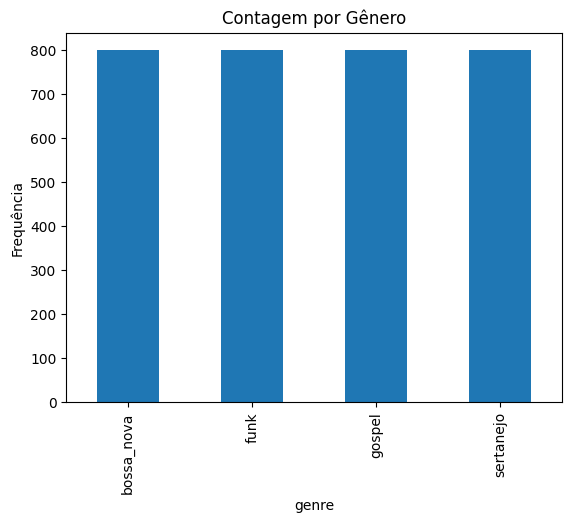

In [17]:
import matplotlib.pyplot as plt
df['genre'].value_counts().plot.bar()
plt.title("Contagem por Gênero")
plt.ylabel("Frequência")
plt.show()

In [18]:
## Inicio de modelagem

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# 1) Separe X e y
X = df['cleaned']
y = df['genre']

In [20]:
## Seraração 80/20 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
#Modelo 1: TF-IDF + Naive Bayes

In [22]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),
        max_features=10_000,
        stop_words=list(stop_pt)
    )),
    ('clf', MultinomialNB())
])

In [23]:
## CrosValidation
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
print("F1-macro (5-fold CV):", cv_scores)
print("Média F1-macro:", cv_scores.mean())

F1-macro (5-fold CV): [0.79596469 0.79943037 0.80415726 0.81890812 0.79202689]
Média F1-macro: 0.802097465611363


In [24]:
# Treinando e validando
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("\n--- Classification Report (test set) ---")
print(classification_report(y_test, y_pred, digits=4))


--- Classification Report (test set) ---
              precision    recall  f1-score   support

  bossa_nova     0.9213    0.7312    0.8153       160
        funk     0.9474    0.6750    0.7883       160
      gospel     0.8957    0.9125    0.9040       160
   sertanejo     0.6102    0.9000    0.7273       160

    accuracy                         0.8047       640
   macro avg     0.8436    0.8047    0.8087       640
weighted avg     0.8436    0.8047    0.8087       640



In [25]:
## Matriz COnfusão

cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
print("--- Confusion Matrix ---")
print(pd.DataFrame(cm, index=pipe.classes_, columns=pipe.classes_))

--- Confusion Matrix ---
            bossa_nova  funk  gospel  sertanejo
bossa_nova         117     3       5         35
funk                 3   108       5         44
gospel               1     0     146         13
sertanejo            6     3       7        144


In [26]:
## Sertanejo com precisão baixa - Melhorar

In [27]:
## GridSearchCV
## Tentativa de Alpha

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {'clf__alpha': [0.01, 0.1, 0.5, 1.0]}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

{'clf__alpha': 0.1} 0.8395394042330511


In [29]:
# Ajuste de Alpha de acordo com o resultado do Grid
pipe.set_params(clf__alpha=0.1)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 stop_words=['na', 'será', 'era', 'numa',
                                             'estivéssemos', 'estejam',
                                             'seremos', 'estiver', 'éramos',
                                             'das', 'fora', 'houvéramos',
                                             'minhas', 'os', 'tivermos', 'ser',
                                             'nas', 'ai', 'mas', 'entre',
                                             'estava', 'vai', 'estamos',
                                             'hajam', 'houvesse', 'terá', 'so',
                                             'estavam', 'aquele', 'terei', ...])),
                ('clf', MultinomialNB(alpha=0.1))])

In [30]:

#Treino com novo parametro
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [31]:
# Resultados

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
print("Matriz de Confusão:")
display(pd.DataFrame(cm, index=pipe.classes_, columns=pipe.classes_))

              precision    recall  f1-score   support

  bossa_nova     0.9143    0.8000    0.8533       160
        funk     0.9197    0.7875    0.8485       160
      gospel     0.9062    0.9062    0.9062       160
   sertanejo     0.6897    0.8750    0.7713       160

    accuracy                         0.8422       640
   macro avg     0.8575    0.8422    0.8449       640
weighted avg     0.8575    0.8422    0.8449       640

Matriz de Confusão:


,bossa_nova,funk,gospel,sertanejo
bossa_nova,128,5,3,24
funk,3,126,5,26
gospel,2,0,145,13
sertanejo,7,6,7,140


In [32]:
## Melhora de precisão e F1 de Sertanej.
## Melhora de f1 Score de Funk, Bossa Nova e Gospel

#Melhoras no Accuracy em Geral.

In [33]:
## Tentativa 3
## Inclusão de char-n-grams

In [34]:
X = df['cleaned']
y = df['genre']

In [35]:
#  uni-grams e bi-grams
word_vect = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=10_000,
    stop_words=list(stop_pt) 
)

#  char n-grams 
char_vect = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 6),
    max_features=5_000
)

In [36]:
# ColumnTransformer 
preproc = ColumnTransformer([
    ('words', word_vect, 'cleaned'),
    ('chars', char_vect, 'cleaned')
])

In [37]:
# Pipeline
pipe_char_nb = Pipeline([
    ('tfidfs', preproc),
    ('clf', MultinomialNB(alpha=0.1))
])

In [38]:
# 5) Validação
scores = cross_val_score(pipe_char_nb, X.to_frame(name='cleaned'), y,
                         cv=5, scoring='f1_macro')
print("F1-macro (word+char-ngrams + NB):", scores)
print("Média F1-macro:", scores.mean())

F1-macro (word+char-ngrams + NB): [0.87669992 0.8609255  0.81887875 0.84059447 0.79379431]
Média F1-macro: 0.8381785892227743


In [39]:
## Resultados T3

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned'], df['genre'],
    test_size=0.2, stratify=df['genre'], random_state=42
)

In [41]:
pipe_char_nb.fit(X_train.to_frame(name='cleaned'), y_train)

y_pred = pipe_char_nb.predict(X_test.to_frame(name='cleaned'))

In [42]:
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

=== Classification Report ===
              precision    recall  f1-score   support

  bossa_nova     0.8936    0.7875    0.8372       160
        funk     0.8958    0.8063    0.8487       160
      gospel     0.9130    0.9187    0.9159       160
   sertanejo     0.6959    0.8438    0.7627       160

    accuracy                         0.8391       640
   macro avg     0.8496    0.8391    0.8411       640
weighted avg     0.8496    0.8391    0.8411       640



In [43]:
#Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=pipe_char_nb.classes_)
cm_df = pd.DataFrame(cm,
                     index=pipe_char_nb.classes_,
                     columns=pipe_char_nb.classes_)
print("=== Matriz de Confusão ===")
display(cm_df)

=== Matriz de Confusão ===


,bossa_nova,funk,gospel,sertanejo
bossa_nova,126,6,3,25
funk,4,129,5,22
gospel,1,0,147,12
sertanejo,10,9,6,135


In [44]:
## Sem grandes melhorias

In [45]:
## Tentativa 4
#Mudança de modelo  - LogisticRegression

In [46]:
X = df['cleaned']
y = df['genre']

In [47]:
# Pipeline: LogisticRegression
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),
        max_features=10_000,
        stop_words=list(stop_pt),
        min_df=2
    )),
    ('clf', LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        C=1.0,
        max_iter=500,
        random_state=42
    ))
])

In [48]:
# Validação

scores_lr = cross_val_score(pipe_lr, X, y, cv=5, scoring='f1_macro')
print("F1-macro LogisticRegression (5-fold):", scores_lr)
print("Média F1-macro:", scores_lr.mean())



F1-macro LogisticRegression (5-fold): [0.85798843 0.8588615  0.80566947 0.83285575 0.80218643]
Média F1-macro: 0.8315123152512536


In [49]:
# Resultados T4

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned'], df['genre'],
    test_size=0.2, stratify=df['genre'], random_state=42
)

In [51]:
# Treino

pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)

In [52]:
# Metricas
print(classification_report(y_test, y_pred, digits=4))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=pipe_lr.classes_)
print("=== Matriz de Confusão ===")
display(pd.DataFrame(cm, index=pipe_lr.classes_, columns=pipe_lr.classes_))


              precision    recall  f1-score   support

  bossa_nova     0.8481    0.8375    0.8428       160
        funk     0.8819    0.7937    0.8355       160
      gospel     0.9024    0.9250    0.9136       160
   sertanejo     0.7356    0.8000    0.7665       160

    accuracy                         0.8391       640
   macro avg     0.8420    0.8391    0.8396       640
weighted avg     0.8420    0.8391    0.8396       640

=== Matriz de Confusão ===


,bossa_nova,funk,gospel,sertanejo
bossa_nova,134,8,2,16
funk,9,127,4,20
gospel,2,0,148,10
sertanejo,13,9,10,128


In [53]:
# Melhorias 

In [ ]:
## Tentativa 5 - LinearSVC + TfidfVectorizer

In [55]:
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),
        max_features=10_000,
        stop_words=list(stop_pt),
        min_df=2
    )),
    ('clf', LinearSVC(
        class_weight='balanced',
        max_iter=5_000,
        random_state=42
    ))
])



In [56]:
# Validação

scores_svc = cross_val_score(pipe_svc, X, y, cv=5, scoring='f1_macro')
print("F1-macro LinearSVC (5-fold):", scores_svc)
print("Média F1-macro:", scores_svc.mean())

F1-macro LinearSVC (5-fold): [0.89819371 0.85697611 0.81441336 0.83695995 0.84383137]
Média F1-macro: 0.8500749001430284


In [57]:
## Resultados T5

In [58]:
pipe_svc.fit(X_train, y_train)
y_pred_svc = pipe_svc.predict(X_test)

In [59]:
#Metricas
print(classification_report(y_test, y_pred_svc, digits=4))

cm_svc = confusion_matrix(y_test, y_pred_svc, labels=pipe_svc.classes_)
print("=== Matriz de Confusão ===")
display(pd.DataFrame(cm_svc, index=pipe_svc.classes_, columns=pipe_svc.classes_))


              precision    recall  f1-score   support

  bossa_nova     0.8476    0.8688    0.8580       160
        funk     0.8851    0.8187    0.8506       160
      gospel     0.9074    0.9187    0.9130       160
   sertanejo     0.7771    0.8063    0.7914       160

    accuracy                         0.8531       640
   macro avg     0.8543    0.8531    0.8533       640
weighted avg     0.8543    0.8531    0.8533       640

=== Matriz de Confusão ===


,bossa_nova,funk,gospel,sertanejo
bossa_nova,139,6,2,13
funk,8,131,4,17
gospel,5,1,147,7
sertanejo,12,10,9,129


In [60]:
## Tentativa 6 Pipeline Multimodal

In [61]:
#Criando Colunas n_words e n_chars

df['n_words'] = df['cleaned'].str.split().apply(len)
df['n_chars'] = df['cleaned'].str.len()


In [62]:
#Pré Processamento

preproc = ColumnTransformer([
    ('txt', TfidfVectorizer(ngram_range=(1,2), max_features=10_000,
                            stop_words=list(stop_pt), min_df=2), 'cleaned'),
    ('num', Pipeline([
        ('sel', FunctionTransformer(lambda X: X[['n_words','n_chars']], validate=False)),
        ('scale', StandardScaler())
    ]), ['n_words','n_chars'])
])

In [63]:
#Pipeline

pipe_multi = Pipeline([
    ('prep', preproc),
    ('clf', LinearSVC(class_weight='balanced', max_iter=5_000, random_state=42))
])

In [64]:
# Validação
scores_multi = cross_val_score(pipe_multi, df, df['genre'], cv=5, scoring='f1_macro')
print("F1-macro multimodal (5-fold):", scores_multi.mean())


F1-macro multimodal (5-fold): 0.8535100249101516


In [65]:
# Resultados - T6

In [66]:
X = df[['cleaned','n_words','n_chars']]
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [67]:
#Pipeline

pipe_multi.fit(X_train, y_train)

y_pred = pipe_multi.predict(X_test)

In [68]:
# Metricas

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=pipe_multi.classes_)
cm_df = pd.DataFrame(cm,
                     index=pipe_multi.classes_,
                     columns=pipe_multi.classes_)
print("=== Matriz de Confusão ===")
display(cm_df)


=== Classification Report ===
              precision    recall  f1-score   support

  bossa_nova     0.8364    0.8625    0.8492       160
        funk     0.8851    0.8187    0.8506       160
      gospel     0.8957    0.9125    0.9040       160
   sertanejo     0.7866    0.8063    0.7963       160

    accuracy                         0.8500       640
   macro avg     0.8509    0.8500    0.8501       640
weighted avg     0.8509    0.8500    0.8501       640

=== Matriz de Confusão ===


,bossa_nova,funk,gospel,sertanejo
bossa_nova,138,8,2,12
funk,8,131,5,16
gospel,6,1,146,7
sertanejo,13,8,10,129


In [ ]:
## O modelo 5 tem um Macro F1 ligeiramente maior, mas o modelo 6 tem um acerto no sertanejo ligeiramente melhor
## Modelo 5 é mais simples, tem uma boa robustez, e a diferença não é tão significante.

#Modelo escolhido: 5 - LinearSVC + TfidfVectorizer